# Assignment 4

### 1. 复习上课内容以及复现课程代码

In [1]:
import numpy as np

class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        for n in self.inputs:
            n.outputs.append(self)

        self.value = None
        
        self.gradients = {}
        

    def forward(self):
        raise NotImplemented
    

    def backward(self):
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()

    for n in  graph[::-1]:
        n.backward()

def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]


losses = []
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

data = load_boston()
X_ = data['data']
y_ = data['target']

X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        X.value = X_batch
        y.value = y_batch

        _ = None
        forward_and_backward(_, graph) # set output node not important.

        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 182.347
Epoch: 101, Loss: 6.605
Epoch: 201, Loss: 6.580
Epoch: 301, Loss: 4.393
Epoch: 401, Loss: 4.884
Epoch: 501, Loss: 3.808
Epoch: 601, Loss: 4.406
Epoch: 701, Loss: 3.892
Epoch: 801, Loss: 3.918
Epoch: 901, Loss: 4.252
Epoch: 1001, Loss: 3.538
Epoch: 1101, Loss: 3.287
Epoch: 1201, Loss: 3.446
Epoch: 1301, Loss: 3.901
Epoch: 1401, Loss: 4.098
Epoch: 1501, Loss: 3.930
Epoch: 1601, Loss: 3.481
Epoch: 1701, Loss: 4.042
Epoch: 1801, Loss: 3.068
Epoch: 1901, Loss: 3.661
Epoch: 2001, Loss: 3.736
Epoch: 2101, Loss: 3.547
Epoch: 2201, Loss: 3.311
Epoch: 2301, Loss: 4.002
Epoch: 2401, Loss: 3.728
Epoch: 2501, Loss: 3.767
Epoch: 2601, Loss: 3.724
Epoch: 2701, Loss: 3.941
Epoch: 2801, Loss: 3.552
Epoch: 2901, Loss: 3.164
Epoch: 3001, Loss: 3.934
Epoch: 3101, Loss: 3.147
Epoch: 3201, Loss: 3.736
Epoch: 3301, Loss: 4.088
Epoch: 3401, Loss: 3.221
Epoch: 3501, Loss: 3.597
Epoch: 3601, Loss: 2.896
Epoch: 3701, Loss: 3.482
Epoch: 3801, Loss: 3.325
Epoc

In [2]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='sigmoid', input_dim=13))
model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_dim=64))
model.add(tf.keras.layers.Dense(1))

model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [3]:
model.fit(X_, y_, epochs=500, batch_size=32)

Train on 506 samples
Epoch 1/500
506/506 [==============================] - 1s 2ms/sample - loss: 142.2903 - mse: 142.2903
Epoch 2/500
506/506 [==============================] - 0s 79us/sample - loss: 63.1810 - mse: 63.1810
Epoch 3/500
506/506 [==============================] - 0s 109us/sample - loss: 46.5026 - mse: 46.5026
Epoch 4/500
506/506 [==============================] - 0s 101us/sample - loss: 37.7618 - mse: 37.7617
Epoch 5/500
506/506 [==============================] - 0s 80us/sample - loss: 30.1853 - mse: 30.1853
Epoch 6/500
506/506 [==============================] - 0s 74us/sample - loss: 26.4742 - mse: 26.4742
Epoch 7/500
506/506 [==============================] - 0s 95us/sample - loss: 24.2501 - mse: 24.2501
Epoch 8/500
506/506 [==============================] - 0s 81us/sample - loss: 23.9674 - mse: 23.9674
Epoch 9/500
506/506 [==============================] - 0s 101us/sample - loss: 22.0256 - mse: 22.0256
Epoch 10/500
506/506 [==============================] - 0s 85us/sa

506/506 [==============================] - 0s 89us/sample - loss: 10.0236 - mse: 10.0236
Epoch 82/500
506/506 [==============================] - 0s 73us/sample - loss: 9.9575 - mse: 9.9575
Epoch 83/500
506/506 [==============================] - 0s 73us/sample - loss: 9.8743 - mse: 9.8743
Epoch 84/500
506/506 [==============================] - 0s 87us/sample - loss: 10.2362 - mse: 10.2362
Epoch 85/500
506/506 [==============================] - 0s 76us/sample - loss: 10.4782 - mse: 10.4782
Epoch 86/500
506/506 [==============================] - 0s 90us/sample - loss: 10.0906 - mse: 10.0906
Epoch 87/500
506/506 [==============================] - 0s 96us/sample - loss: 9.9287 - mse: 9.9287
Epoch 88/500
506/506 [==============================] - 0s 93us/sample - loss: 10.3261 - mse: 10.3261
Epoch 89/500
506/506 [==============================] - 0s 95us/sample - loss: 10.0293 - mse: 10.0293
Epoch 90/500
506/506 [==============================] - 0s 106us/sample - loss: 9.6444 - mse: 9.6444


506/506 [==============================] - 0s 64us/sample - loss: 6.6101 - mse: 6.6101
Epoch 163/500
506/506 [==============================] - 0s 60us/sample - loss: 6.6171 - mse: 6.6171
Epoch 164/500
506/506 [==============================] - 0s 58us/sample - loss: 6.5034 - mse: 6.5034
Epoch 165/500
506/506 [==============================] - 0s 82us/sample - loss: 6.8488 - mse: 6.8488
Epoch 166/500
506/506 [==============================] - 0s 52us/sample - loss: 6.6965 - mse: 6.6965
Epoch 167/500
506/506 [==============================] - 0s 86us/sample - loss: 6.5972 - mse: 6.5972
Epoch 168/500
506/506 [==============================] - 0s 77us/sample - loss: 6.6373 - mse: 6.6373
Epoch 169/500
506/506 [==============================] - 0s 53us/sample - loss: 6.3791 - mse: 6.3791
Epoch 170/500
506/506 [==============================] - 0s 89us/sample - loss: 6.4731 - mse: 6.4731
Epoch 171/500
506/506 [==============================] - 0s 110us/sample - loss: 6.5655 - mse: 6.5655
Epo

Epoch 243/500
506/506 [==============================] - 0s 105us/sample - loss: 4.8528 - mse: 4.8528
Epoch 244/500
506/506 [==============================] - 0s 101us/sample - loss: 5.0374 - mse: 5.0374
Epoch 245/500
506/506 [==============================] - 0s 87us/sample - loss: 4.7967 - mse: 4.7967
Epoch 246/500
506/506 [==============================] - 0s 88us/sample - loss: 4.8856 - mse: 4.8856
Epoch 247/500
506/506 [==============================] - 0s 93us/sample - loss: 4.6510 - mse: 4.6510
Epoch 248/500
506/506 [==============================] - 0s 107us/sample - loss: 4.7621 - mse: 4.7621
Epoch 249/500
506/506 [==============================] - 0s 118us/sample - loss: 4.6738 - mse: 4.6738
Epoch 250/500
506/506 [==============================] - 0s 104us/sample - loss: 4.7618 - mse: 4.7618
Epoch 251/500
506/506 [==============================] - 0s 93us/sample - loss: 5.0145 - mse: 5.0145
Epoch 252/500
506/506 [==============================] - 0s 120us/sample - loss: 4.877

506/506 [==============================] - 0s 119us/sample - loss: 3.9802 - mse: 3.9802
Epoch 324/500
506/506 [==============================] - 0s 88us/sample - loss: 3.9014 - mse: 3.9014
Epoch 325/500
506/506 [==============================] - 0s 90us/sample - loss: 4.1160 - mse: 4.1160
Epoch 326/500
506/506 [==============================] - 0s 85us/sample - loss: 4.0834 - mse: 4.0834
Epoch 327/500
506/506 [==============================] - 0s 85us/sample - loss: 3.9887 - mse: 3.9887
Epoch 328/500
506/506 [==============================] - 0s 81us/sample - loss: 4.0160 - mse: 4.0160
Epoch 329/500
506/506 [==============================] - 0s 94us/sample - loss: 3.8797 - mse: 3.8797
Epoch 330/500
506/506 [==============================] - 0s 98us/sample - loss: 4.1530 - mse: 4.1530
Epoch 331/500
506/506 [==============================] - 0s 111us/sample - loss: 3.9232 - mse: 3.9232
Epoch 332/500
506/506 [==============================] - 0s 125us/sample - loss: 3.8089 - mse: 3.8089
E

506/506 [==============================] - 0s 94us/sample - loss: 3.3736 - mse: 3.3736
Epoch 404/500
506/506 [==============================] - 0s 74us/sample - loss: 3.4599 - mse: 3.4599
Epoch 405/500
506/506 [==============================] - 0s 73us/sample - loss: 3.3253 - mse: 3.3253
Epoch 406/500
506/506 [==============================] - 0s 78us/sample - loss: 3.2729 - mse: 3.2729
Epoch 407/500
506/506 [==============================] - 0s 62us/sample - loss: 3.3047 - mse: 3.3047
Epoch 408/500
506/506 [==============================] - 0s 71us/sample - loss: 3.2390 - mse: 3.2390
Epoch 409/500
506/506 [==============================] - 0s 65us/sample - loss: 3.2541 - mse: 3.2541
Epoch 410/500
506/506 [==============================] - 0s 65us/sample - loss: 3.3193 - mse: 3.3193
Epoch 411/500
506/506 [==============================] - 0s 69us/sample - loss: 3.2651 - mse: 3.2651
Epoch 412/500
506/506 [==============================] - 0s 70us/sample - loss: 3.3914 - mse: 3.3914
Epoc

506/506 [==============================] - 0s 112us/sample - loss: 2.9569 - mse: 2.9569
Epoch 484/500
506/506 [==============================] - 0s 129us/sample - loss: 2.9096 - mse: 2.9096
Epoch 485/500
506/506 [==============================] - 0s 92us/sample - loss: 2.8752 - mse: 2.8752
Epoch 486/500
506/506 [==============================] - 0s 64us/sample - loss: 2.8252 - mse: 2.8252
Epoch 487/500
506/506 [==============================] - 0s 90us/sample - loss: 2.8929 - mse: 2.8929
Epoch 488/500
506/506 [==============================] - 0s 78us/sample - loss: 2.8240 - mse: 2.8240
Epoch 489/500
506/506 [==============================] - 0s 51us/sample - loss: 2.9094 - mse: 2.9094
Epoch 490/500
506/506 [==============================] - 0s 70us/sample - loss: 2.8011 - mse: 2.8011
Epoch 491/500
506/506 [==============================] - 0s 61us/sample - loss: 2.9275 - mse: 2.9275
Epoch 492/500
506/506 [==============================] - 0s 73us/sample - loss: 2.7314 - mse: 2.7314
Ep

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

神经元使用非线性激活函数（Sigmoid、ReLu等）对线性函数（wx+b）进行计算。

####  2. Why we use non-linear activation funcitons in neural networks?

因为如果使用线性激活函数的话，多层神经网络与单层的效果一样。

#### 3. What is the 'Logistic Loss' ?

$Loss = -(y*\log \hat{y} + (1-y)\log(1-\hat{y}))$

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

C.Sigmoid

#### 5. Why we don't use zero initialization for all parameters ?

如果所有参数的初始值都是0，则后面的隐藏层和输出层的结果都为零，导致梯度消失，神经网络将学不到任何东西。

#### 6. Can you implement the softmax function using python ? 

In [4]:
import math
def softmax(a:list):
    total = sum(math.exp(i) for i in a)
    return [math.exp(i) / total for i in a]

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [5]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [36]:
# Loading the data 
digits = datasets.load_digits()

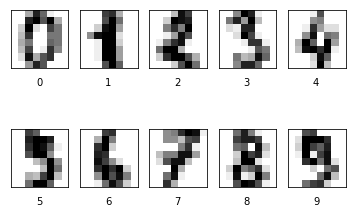

In [37]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [38]:
# Split the data into training set and test set 

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [39]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [40]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347, 1)
(450, 1)


#### 3- Architecture of the neural network

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [42]:
import numpy as np
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1 / (1 + np.exp(-z))
    
    return s

In [43]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([-10,0,100]) = " + str(sigmoid(np.array([-10,0,100]))))

sigmoid([-10,0,100]) = [4.53978687e-05 5.00000000e-01 1.00000000e+00]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [44]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.random((dim,1))
    b = np.random.random()
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [45]:
initialize_parameters(10)

(array([[0.70510704],
        [0.10440858],
        [0.51509255],
        [0.64678648],
        [0.34501852],
        [0.14580832],
        [0.10768875],
        [0.07441426],
        [0.20032451],
        [0.97285245]]), 0.2604728989795829)

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [46]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    
    m = X.shape[0]
    A = sigmoid(X.dot(w) + b)
    cost = sum(-y*np.log(a)-(1-y)*np.log(1-a) for y,a in zip(Y,A)) / m
    
    dw = np.dot(X.T,(A-Y)) / m
    db = np.sum(A-Y) / m    
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

In [47]:
w, b = initialize_parameters(10)
X = np.random.random((100,10))
Y = np.array([np.random.choice([0,1]) for _ in range(100)]).reshape(100,1)
grads, cost = propagate(w, b, X, Y)

In [48]:
cost

array(1.71432883)

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [49]:
def optimize(w, b, X, Y, num_iterations, lr, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - lr * dw
        b = b - lr * db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    return params, grads, costs

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [50]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments: 
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]
    Y_prediction = np.zeros((m,1))
    A = sigmoid(X.dot(w) + b)
    for i in range(A.shape[0]):
        if A[i,0] < 0.5:
            Y_prediction[i,0] = 0
        else:
            Y_prediction[i,0] = 1
    
    assert(Y_prediction.shape == (m,1))
    
    return Y_prediction

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [51]:
def model(X_train, y_train, X_test, y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    w, b = initialize_parameters(X_train.shape[1])
    params, grads, costs = optimize(w, b, X_train, y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
    
    y_train_pred = predict(w, b, X_train)
    training_accuracy = sum(y_train_pred == y_train) / y_train.shape[0]
    
    y_test_pred = predict(w, b, X_test)
    test_accuracy = sum(y_test_pred == y_test) / y_test.shape[0]
    
    d = {"w":w,
         "b":b,
         "training_accuracy": training_accuracy,
         "test_accuracy":test_accuracy,
         "costs":costs}
    return d
    

In [52]:
d = model(X_train, y_train, X_test, y_test, num_iterations=1000, learning_rate=1e-2,print_cost=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


In [53]:
d['training_accuracy'],d['test_accuracy'],d['costs']

(array([0.88938382]),
 array([0.87555556]),
 [array(nan),
  array(nan),
  array(nan),
  array(0.43079217),
  array(0.36875416),
  array(0.33923772),
  array(0.32250647),
  array(0.31171687),
  array(0.3041157),
  array(0.29842249)])

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

In [54]:
lrs = np.logspace(-9, 0, 10)
test_acc, train_acc = [], []
for lr in lrs:
    d = model(X_train, y_train, X_test, y_test, num_iterations=1000, learning_rate=lr,print_cost=False)
    train_acc.append(d['training_accuracy'])
    test_acc.append(d['test_accuracy'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


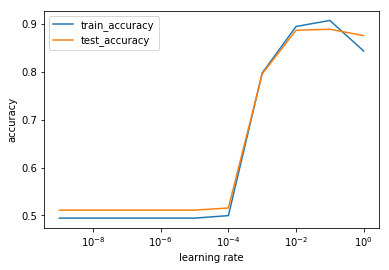

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(lrs, train_acc, label='train_accuracy')
ax.plot(lrs, test_acc, label='test_accuracy')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
ax.legend()

可以看出，当learning rate在0.01左右时，train accuracy和test accuray最高。

##### 4.2 Observe the effect of iteration_num on the test accuracy.

In [26]:
iters = [100,500,1000,5000,10000]
test_acc, train_acc = [], []
for num in iters:
    d = model(X_train, y_train, X_test, y_test, num_iterations=int(num), learning_rate=1e-2,print_cost=False)
    train_acc.append(d['training_accuracy'])
    test_acc.append(d['test_accuracy'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


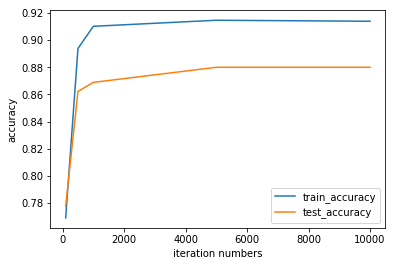

In [27]:
fig, ax = plt.subplots()
ax.plot(iters, train_acc, label='train_accuracy')
ax.plot(iters, test_acc, label='test_accuracy')
plt.xlabel('iteration numbers')
plt.ylabel('accuracy')
ax.legend()

可以看出，当iteration numbers在1000以上时，training accuracy和test accuracy都会维持在较高的数值（85%以上）。继续增加iteration number，对accuracy的提高程度有限。

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

In [28]:
digits = datasets.load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#w，b参数初始化，w(64,10) b(10,)
def initialize_parameters_10(feature_dim, target_dim=10):
    w = np.random.random((feature_dim,target_dim))
    b = np.random.random((target_dim, ))
    return w,b

#softmax函数的输入为矩阵
def softmax(x):
    x = x - x.max(axis=1, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=1, keepdims=True)

#计算cross entropy，A为softmax函数的预测值，A(num,target_class), y(num,1)而非onehot
def cross_entropy(A, y):
    m = A.shape[0]
    loss = 0
    for i, y_i in enumerate(y):
        loss += -np.log(A[i,y_i])
    return loss / m

def onehot(y):
    m = y.shape[0]
    y_onehot = np.zeros((m,10))
    for i in range(m):
        y_onehot[i,y[i,0]] = 1
    return y_onehot

def propagate_10(w,b,X,Y):
    m = X.shape[0]
    A = softmax(X.dot(w) + b) #A[m,10]
    cost = cross_entropy(A, Y) 
    
    Y_onehot = onehot(Y)
    assert Y_onehot.shape == A.shape
    #dw, db的公式与二分类的logistic loss一样，Y取onehot后的值，与经softmax计算的A的维度保持一样
    dw = np.dot(X.T,(A-Y_onehot)) / m
    db = np.sum(A-Y_onehot, axis=0) / m  
    
    assert dw.shape == w.shape
    assert db.shape == b.shape
    
    cost = np.squeeze(cost)
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

#与二分类的optimize计算完全一样
def optimize_10(w, b, X, Y, num_iterations, lr, print_cost):
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate_10(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - lr * dw
        b = b - lr * db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    return params, grads, costs

#这里根据w，b计算后，经softmax函数，取argmax为预测的Y值。
def predict_10(w, b, X):
    A = softmax(X.dot(w) + b)
    Y_prediction = A.argmax(axis=1)    
    return Y_prediction.reshape(-1,1)

def model_10(X_train, y_train, X_test, y_test, num_iterations, learning_rate, print_cost, n_class=10):
 
    w, b = initialize_parameters_10(X_train.shape[1], n_class)
    params, grads, costs = optimize_10(w, b, X_train, y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
    
    y_train_pred = predict_10(w, b, X_train)
    training_accuracy = sum(y_train_pred == y_train) / y_train.shape[0]
    
    y_test_pred = predict_10(w, b, X_test)
    test_accuracy = sum(y_test_pred == y_test) / y_test.shape[0]
    
    d = {"w":w,
         "b":b,
         "training_accuracy": training_accuracy,
         "test_accuracy":test_accuracy,
         "costs":costs}
    return d
    

In [29]:
d = model_10(X_train, y_train, X_test, y_test, num_iterations=1000, learning_rate=1e-3,print_cost=True)

Cost after iteration 0: 30.381748
Cost after iteration 100: 10.326082
Cost after iteration 200: 6.544870
Cost after iteration 300: 4.435820
Cost after iteration 400: 3.203702
Cost after iteration 500: 2.486431
Cost after iteration 600: 2.007459
Cost after iteration 700: 1.658831
Cost after iteration 800: 1.394266
Cost after iteration 900: 1.192119


In [30]:
d['training_accuracy'], d['test_accuracy']

(array([0.79213066]), array([0.77111111]))

经过1000次的迭代训练后，training accuracy为79.2%， test accuracy为77.2%.

# Congratulations ! You have completed assigment 4. 